In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [7]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '41-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [8]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [9]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [10]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.75.59.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [11]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB3',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [12]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [13]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [14]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000284 to 5.09e-05


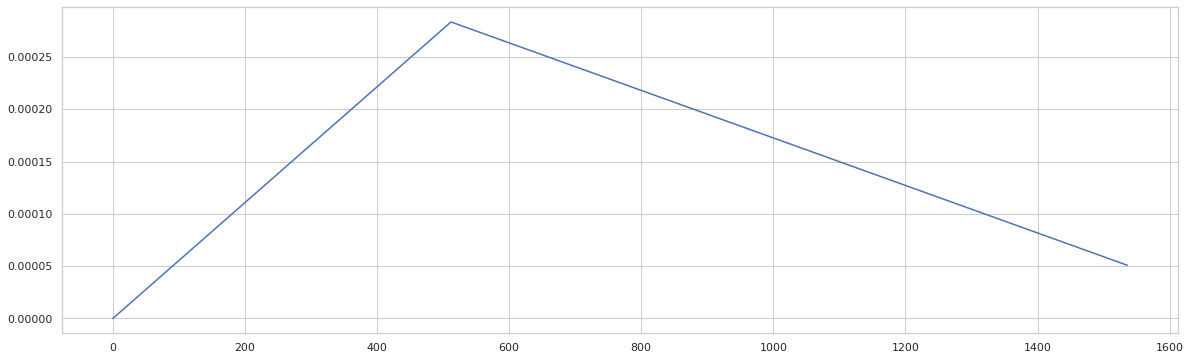

In [15]:
#@title
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [16]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [17]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
        
        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/20
93/93 - 38s - loss: 0.5746 - auc: 0.5677 - val_loss: 0.3437 - val_auc: 0.6311
Epoch 2/20
93/93 - 24s - loss: 0.2859 - auc: 0.8653 - val_loss: 0.3086 - val_auc: 0.7895
Epoch 3/20
93/93 - 24s - loss: 0.2672 - auc: 0.8962 - val_loss: 0.2661 - val_auc: 0.8940
Epoch 4/20
93/93 - 24s - loss: 0.2549 - auc: 0.9124 - val_loss: 0.2547 - val_auc: 0.9177
Epoch 5/20
93/93 - 24s - loss: 0.2465 - auc: 0.9232 - val_loss: 0.2501 - val_auc: 0.9173
Epoch 6/20
93/93 - 24s - loss: 0.2381 - auc: 0.9321 - val_loss: 0.2320 - val_auc: 0.9393
Epoch 7/20
93/93 - 24s - loss: 0.2296 - auc: 0.9418 - val_loss: 0.2228 - val_auc: 0.9445
Epoch 8/20
93/93 - 24s - loss: 0.2205 - auc: 0.9497 - val_loss: 0.2209 - val_auc: 0.9463
Epoch 9/20
93/93 - 24s - loss: 0.2139 - auc: 0.9559 - val_loss: 0.2205 - val_auc: 0.9478
Epoch 10/20
93/93 - 24s - loss: 0.2079 - auc: 0.9584 - val_loss: 0.2157 - val_auc: 0.9509
Epoch 11/20
93/93 - 22s - loss: 0.2019 - auc

INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 38s - loss: 0.5605 - auc: 0.5617 - val_loss: 0.3492 - val_auc: 0.6356
Epoch 2/20
93/93 - 24s - loss: 0.2831 - auc: 0.8690 - val_loss: 0.3095 - val_auc: 0.8057
Epoch 3/20
93/93 - 34s - loss: 0.2645 - auc: 0.8992 - val_loss: 0.3009 - val_auc: 0.8653
Epoch 4/20
93/93 - 24s - loss: 0.2527 - auc: 0.9136 - val_loss: 0.2633 - val_auc: 0.9121
Epoch 5/20
93/93 - 24s - loss: 0.2443 - auc: 0.9250 - val_loss: 0.2506 - val_auc: 0.9202
Epoch 6/20
93/93 - 24s - loss: 0.2356 - auc: 0.9347 - val_loss: 0.2415 - val_auc: 0.9329
Epoch 7/20
93/93 - 24s - loss: 0.2269 - auc: 0.9434 - val_loss: 0.2283 - val_auc: 0.9417
Epoch 8/20
93/93 - 24s - loss: 0.2174 - auc: 0.9513 - val_loss: 0.2232 - val_auc: 0.9467
Epoch 9/20
93/93 - 25s - loss: 0.2123 - auc: 0.9582 - val_loss: 0.2216 - val_auc: 0.9497
Epoch 10/20
93/93 - 24s - loss: 0.2055 - auc: 0.9622 - val_loss: 0.2161 - val_auc: 0.9519
Epoch 11/20
93/93 - 22s - loss: 0.1981 - auc: 0.9668 - val_loss: 0.2203 - val_auc: 0.9511
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.59.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 38s - loss: 0.5177 - auc: 0.5993 - val_loss: 0.3513 - val_auc: 0.6658
Epoch 2/20
97/97 - 25s - loss: 0.2804 - auc: 0.8740 - val_loss: 0.3234 - val_auc: 0.8029
Epoch 3/20
97/97 - 25s - loss: 0.2610 - auc: 0.9023 - val_loss: 0.2762 - val_auc: 0.8905
Epoch 4/20
97/97 - 25s - loss: 0.2517 - auc: 0.9150 - val_loss: 0.2622 - val_auc: 0.9176
Epoch 5/20
97/97 - 25s - loss: 0.2408 - auc: 0.9283 - val_loss: 0.2537 - val_auc: 0.9247
Epoch 6/20
97/97 - 25s - loss: 0.2329 - auc: 0.9375 - val_loss: 0.2472 - val_auc: 0.9357
Epoch 7/20
97/97 - 25s - loss: 0.2238 - auc: 0.9458 - val_loss: 0.2346 - val_auc: 0.9389
Epoch 8/20
97/97 - 25s - loss: 0.2162 - auc: 0.9514 - val_loss: 0.2332 - val_auc: 0.9396
Epoch 9/20
97/97 - 25s - loss: 0.2091 - auc: 0.9571 - val_loss: 0.2303 - val_auc: 0.9436
Epoch 10/20
97/97 - 26s - loss: 0.2041 - auc: 0.9610 - val_loss: 0.2257 - val_auc: 0.9469
Epoch 11/20
97/97 - 23s - loss: 0.1979 - auc: 0.9668 - val_loss: 0.2284 - val_auc: 0.9468
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


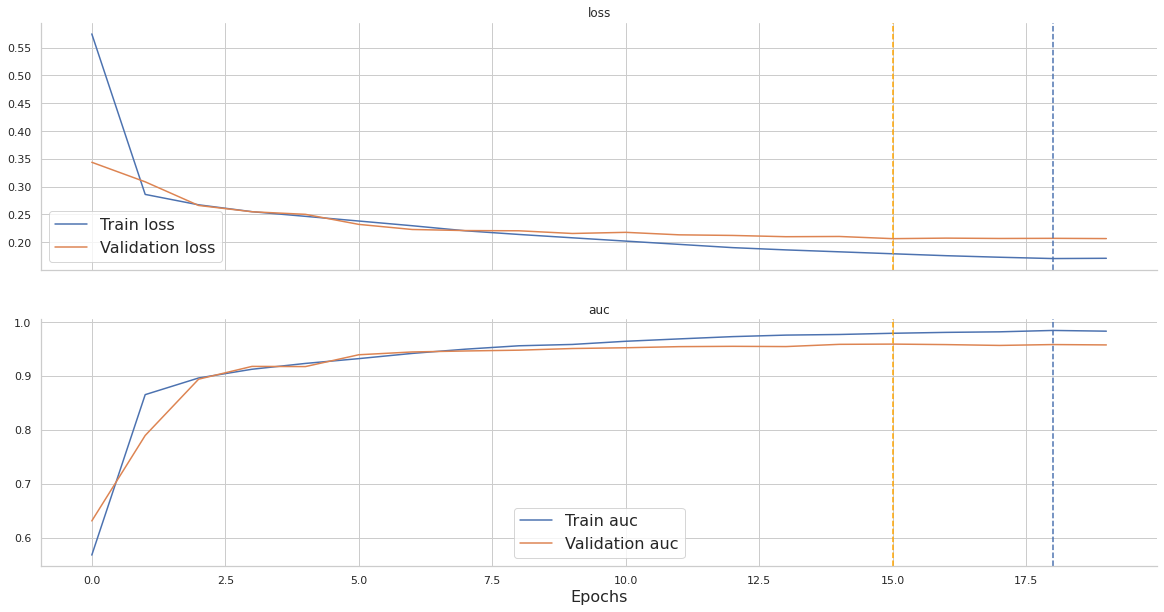

Fold: 2


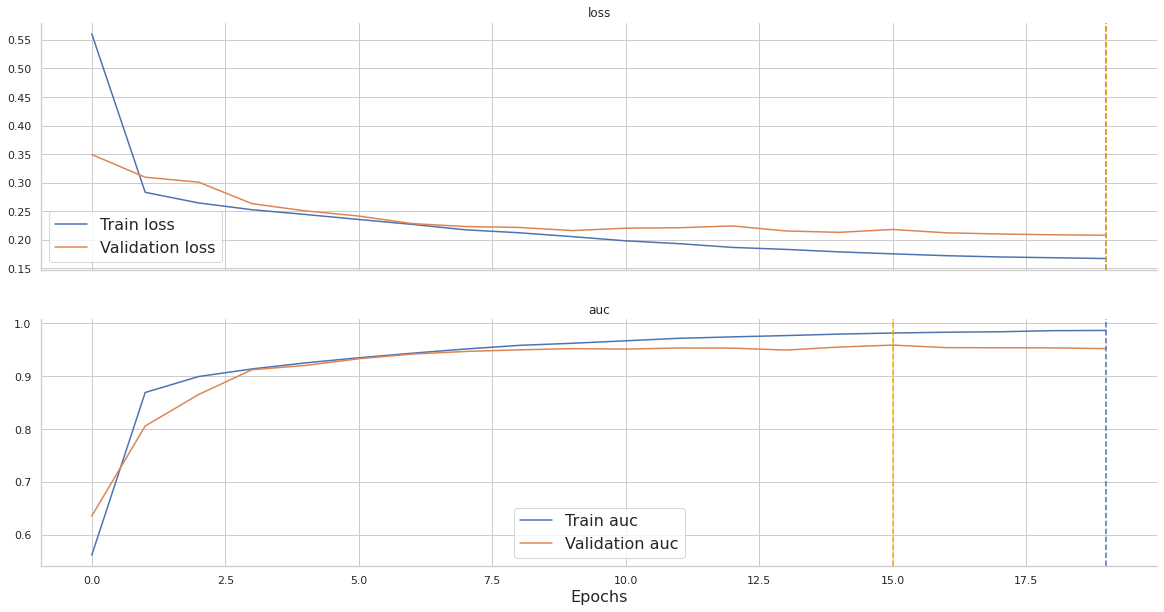

Fold: 3


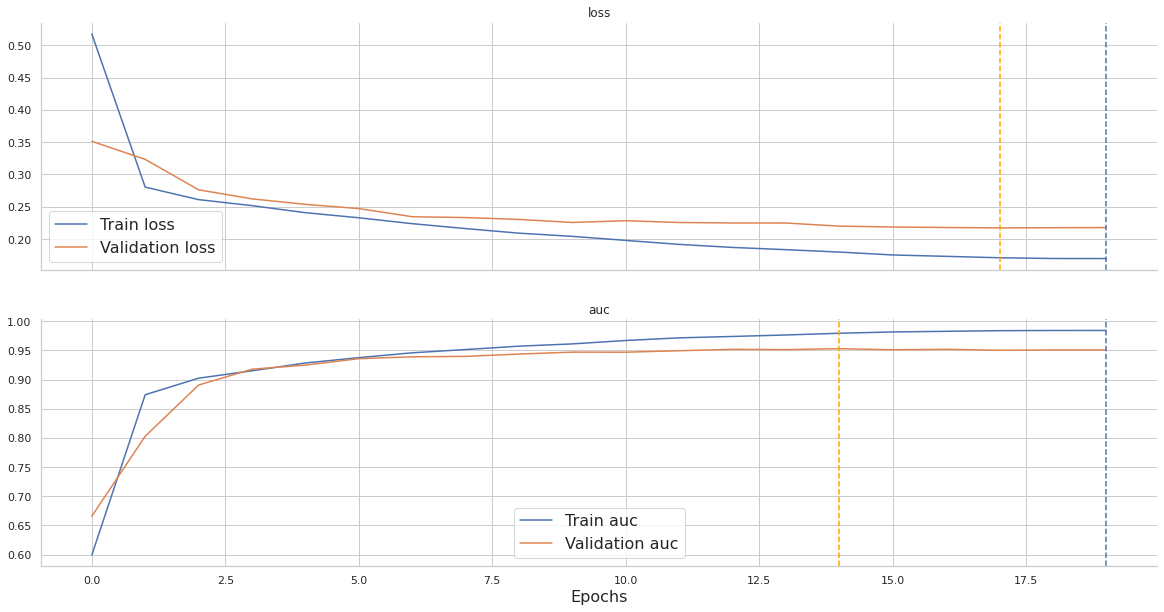

In [18]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

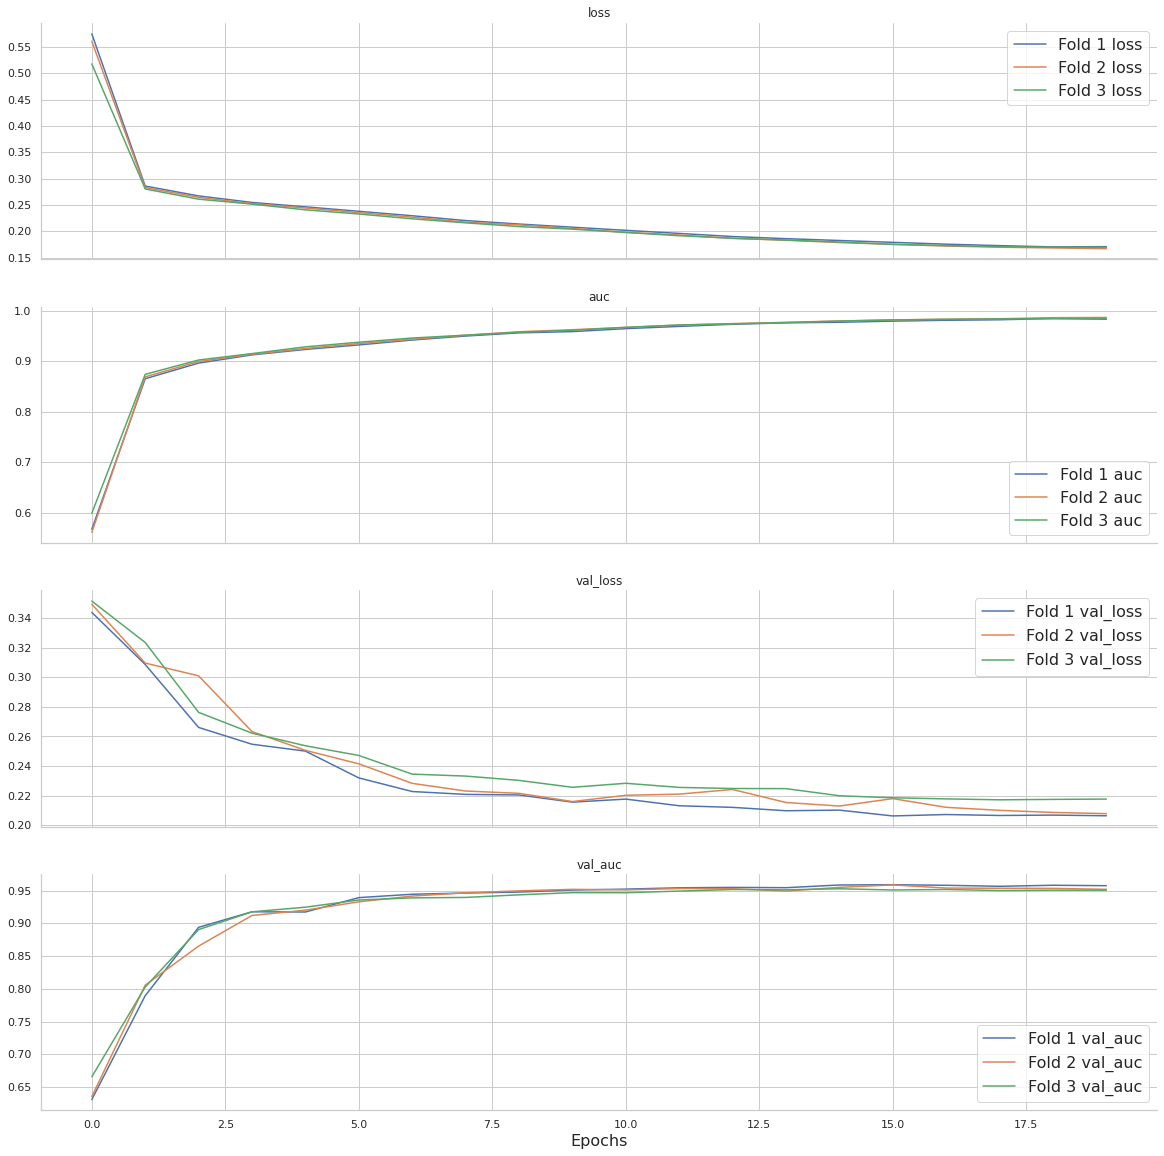

In [19]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [20]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.979759,0.889153,0.090605,0.976242,0.903552,0.983791,0.883760,0.979243,0.880148
Accuracy,0.992594,0.981061,0.011533,0.992191,0.983398,0.992975,0.980118,0.992617,0.979668
Precision,0.903662,0.442133,0.461529,0.909366,0.464789,0.918429,0.413333,0.883191,0.448276
Recall,0.649537,0.263527,0.386010,0.631027,0.308411,0.658009,0.254098,0.659574,0.228070
F1-score,0.755645,0.329278,0.426367,0.745050,0.370787,0.766709,0.314721,0.755177,0.302326
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [21]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.979759,0.889153,0.090605,0.976242,0.903552,0.983791,0.883760,0.979243,0.880148
male,0.982049,0.885813,0.096235,0.978266,0.900725,0.984931,0.896346,0.982949,0.860369
female,0.975990,0.896564,0.079426,0.972498,0.906512,0.981575,0.858286,0.973896,0.924894
head/neck,0.988960,0.871900,0.117059,0.977599,0.959065,0.993674,0.846070,0.995605,0.810565
upper extremity,0.979572,0.901307,0.078264,0.980344,0.927854,0.984246,0.878032,0.974125,0.898037
lower extremity,0.970243,0.843681,0.126562,0.963008,0.846154,0.982106,0.814179,0.965614,0.870710
torso,0.981960,0.910250,0.071710,0.980514,0.903362,0.982514,0.912063,0.982851,0.915323
0 <= age < 26,0.950043,0.875128,0.074915,0.944695,0.902174,0.972766,0.801913,0.932668,0.921296
26 <= age < 40,0.978135,0.847572,0.130563,0.980367,0.721657,0.984346,0.875276,0.969691,0.945783


# Model evaluation (best)

In [22]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.978523,0.893157,0.085366,0.972984,0.912830,0.983786,0.883117,0.978799,0.883523
Accuracy,0.992240,0.981625,0.010615,0.991092,0.984287,0.992937,0.980412,0.992690,0.980176
Precision,0.896508,0.469057,0.427451,0.887821,0.507937,0.915663,0.424658,0.886040,0.474576
Recall,0.633475,0.266259,0.367215,0.580713,0.299065,0.658009,0.254098,0.661702,0.245614
F1-score,0.741837,0.339373,0.402464,0.702155,0.376471,0.765743,0.317949,0.757613,0.323699
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.978523,0.893157,0.085366,0.972984,0.912830,0.983786,0.883117,0.978799,0.883523
male,0.980794,0.889481,0.091314,0.974841,0.907474,0.984906,0.895664,0.982636,0.865304
female,0.974770,0.900260,0.074510,0.969475,0.919967,0.981594,0.857712,0.973241,0.923100
head/neck,0.988412,0.873415,0.114998,0.976373,0.953263,0.993758,0.844806,0.995106,0.822175
upper extremity,0.978359,0.898478,0.079881,0.977222,0.919786,0.983967,0.876473,0.973889,0.899176
lower extremity,0.968691,0.856858,0.111833,0.959605,0.882824,0.981938,0.814444,0.964531,0.873306
torso,0.980756,0.910601,0.070155,0.976999,0.904208,0.982696,0.911932,0.982572,0.915662
0 <= age < 26,0.949182,0.871617,0.077565,0.941479,0.890761,0.973008,0.804645,0.933057,0.919444
26 <= age < 40,0.977594,0.878152,0.099442,0.980078,0.812016,0.984244,0.875671,0.968459,0.946769


# Confusion matrix

Fold: 1


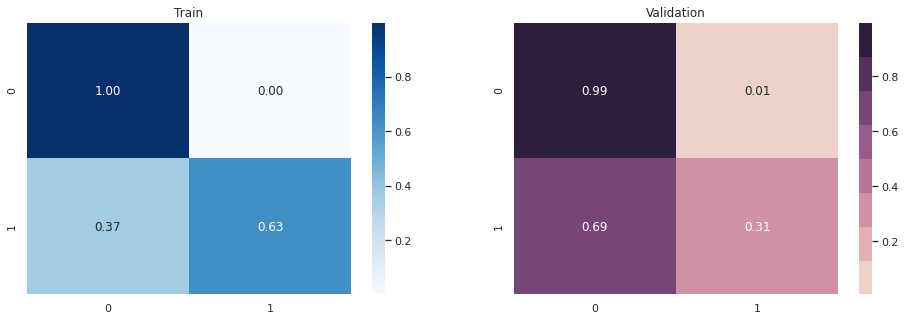

Fold: 2


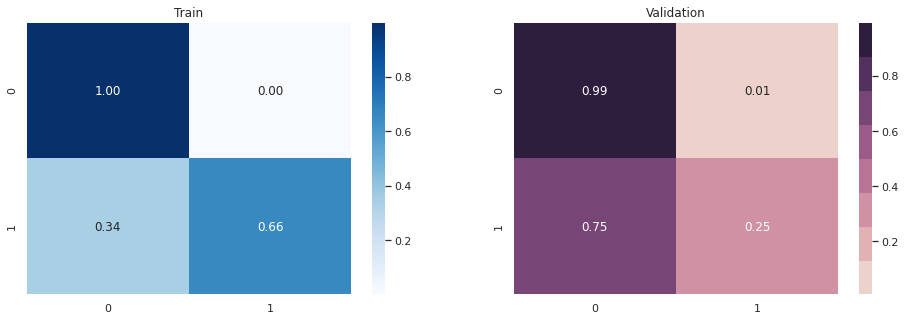

Fold: 3


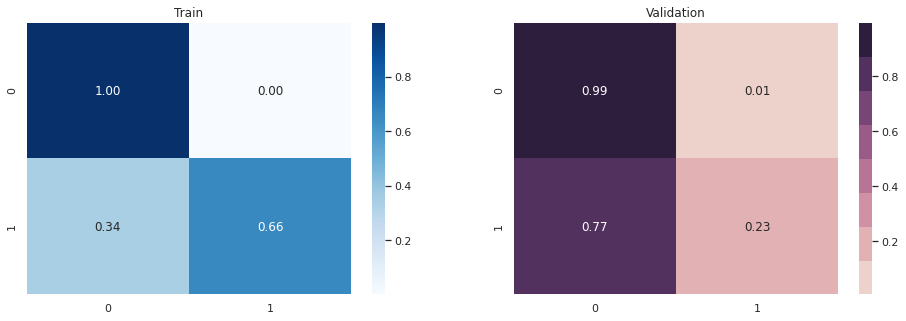

In [23]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [24]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.017529,0.030097,0.029901,0.027649
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.015520,0.028712,0.024180,0.024706
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.017170,0.026525,0.027421,0.031902
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.017633,0.031111,0.029648,0.027406
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015148,0.024118,0.026683,0.024939
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024164,0.037250,0.055419,0.028150
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.022914,0.055315,0.027843,0.031414
7,ISIC_0075663,female,35.0,torso,unknown,0,0.017815,0.029888,0.030350,0.028840
8,ISIC_0075914,male,30.0,torso,unknown,0,0.019151,0.025923,0.039095,0.030738
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.016676,0.027383,0.026977,0.029021


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.018003,0.028264,0.031840,0.029910
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.107349,0.183839,0.047397,0.305509
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.376313,0.926102,0.040723,0.914739
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.399677,0.969198,0.088301,0.940884
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.506556,0.966580,0.742378,0.823823
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.564451,0.883699,0.972705,0.965849
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.138882,0.041282,0.435592,0.217536
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.204329,0.159849,0.354246,0.507551
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.206643,0.128336,0.264757,0.640123
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.183043,0.295617,0.587224,0.032374


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.506556,0.966580,0.742378,0.823823
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.564451,0.883699,0.972705,0.965849
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.579831,0.977412,0.961879,0.959865
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.554599,0.855641,0.965592,0.951764
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.582329,0.965487,0.991809,0.954349
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.573414,0.961691,0.968829,0.936550
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.575739,0.956783,0.985525,0.936387
1568,ISIC_0572205,male,20.0,torso,melanoma,1,0.566306,0.949390,0.952118,0.930022
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.576300,0.933342,0.976075,0.972083
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.593809,0.992362,0.985086,0.991600


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 169
Train positive correct predictions: 166


# Make predictions (best)

In [25]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_3.h5


In [26]:
#@title
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/model_fold_3.h5
Running TTA


# Make predictions (last)

In [27]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_3.h5


In [28]:
#@title
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    print('Running TTA')
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_1.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_2.h5
Running TTA
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/41-efficientnetb0/last_model_fold_3.h5
Running TTA


# Visualize test predictions

In [29]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 113|10869
Test predictions (last) 111|10871
Test predictions 108|10874
Test predictions (last) 115|10867
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.027323,0.027132,0.026620,0.025801
1,ISIC_0052349,male,40.0,lower extremity,0.028205,0.027793,0.027291,0.027523
2,ISIC_0058510,female,55.0,torso,0.026226,0.026050,0.026615,0.025145
3,ISIC_0073313,female,50.0,torso,0.027505,0.027634,0.027137,0.027101
4,ISIC_0073502,female,45.0,lower extremity,0.026650,0.026159,0.026235,0.026067
5,ISIC_0074618,male,50.0,lower extremity,0.035156,0.035338,0.030682,0.031162
6,ISIC_0076801,male,45.0,upper extremity,0.029457,0.028742,0.027847,0.027900
7,ISIC_0077586,male,50.0,lower extremity,0.038238,0.037391,0.044040,0.043090
8,ISIC_0082004,female,45.0,torso,0.026806,0.026375,0.027861,0.027646
9,ISIC_0082785,male,65.0,lower extremity,0.027805,0.027318,0.028198,0.027614


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.817669,0.838176,0.853044,0.855725
102,ISIC_0208233,female,60.0,lower extremity,0.874367,0.875134,0.945958,0.879279
255,ISIC_0351156,male,40.0,head/neck,0.899313,0.899258,0.946033,0.918719
296,ISIC_0391046,male,85.0,torso,0.560956,0.547313,0.615953,0.613401
403,ISIC_0481105,male,80.0,torso,0.816980,0.822662,0.858423,0.889436
471,ISIC_0539432,female,45.0,lower extremity,0.941914,0.941590,0.919162,0.932144
552,ISIC_0606244,male,70.0,torso,0.937349,0.941894,0.800565,0.836185
596,ISIC_0637104,female,80.0,torso,0.572649,0.568669,0.597184,0.590797
727,ISIC_0740997,male,40.0,torso,0.554728,0.552477,0.226459,0.262999
764,ISIC_0775584,female,35.0,lower extremity,0.506710,0.526834,0.452736,0.521635


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.817669,0.838176,0.853044,0.855725
102,ISIC_0208233,female,60.0,lower extremity,0.874367,0.875134,0.945958,0.879279
255,ISIC_0351156,male,40.0,head/neck,0.899313,0.899258,0.946033,0.918719
296,ISIC_0391046,male,85.0,torso,0.560956,0.547313,0.615953,0.613401
403,ISIC_0481105,male,80.0,torso,0.816980,0.822662,0.858423,0.889436
471,ISIC_0539432,female,45.0,lower extremity,0.941914,0.941590,0.919162,0.932144
552,ISIC_0606244,male,70.0,torso,0.937349,0.941894,0.800565,0.836185
596,ISIC_0637104,female,80.0,torso,0.572649,0.568669,0.597184,0.590797
727,ISIC_0740997,male,40.0,torso,0.554728,0.552477,0.226459,0.262999
764,ISIC_0775584,female,35.0,lower extremity,0.506710,0.526834,0.452736,0.521635


# Test set predictions

In [34]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.027323,0.027132,0.027227,0.026620,0.025801,0.026211
1,ISIC_0052349,0.028205,0.027793,0.027999,0.027291,0.027523,0.027407
2,ISIC_0058510,0.026226,0.026050,0.026138,0.026615,0.025145,0.025880
3,ISIC_0073313,0.027505,0.027634,0.027569,0.027137,0.027101,0.027119
4,ISIC_0073502,0.026650,0.026159,0.026405,0.026235,0.026067,0.026151
5,ISIC_0074618,0.035156,0.035338,0.035247,0.030682,0.031162,0.030922
6,ISIC_0076801,0.029457,0.028742,0.029100,0.027847,0.027900,0.027874
7,ISIC_0077586,0.038238,0.037391,0.037814,0.044040,0.043090,0.043565
8,ISIC_0082004,0.026806,0.026375,0.026590,0.027861,0.027646,0.027754
9,ISIC_0082785,0.027805,0.027318,0.027562,0.028198,0.027614,0.027906


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.046247,0.045911,0.046079,0.046961,0.046890,0.046925
std,0.086509,0.087185,0.086784,0.082537,0.083892,0.082944
min,0.020426,0.020485,0.020456,0.021048,0.021057,0.021053
25%,0.026967,0.026806,0.026891,0.027115,0.026961,0.027047
50%,0.028820,0.028558,0.028691,0.029361,0.029110,0.029265
75%,0.033333,0.032619,0.032984,0.035021,0.034432,0.034875
max,0.989496,0.989847,0.989672,0.991357,0.990935,0.991146
